# Prédiction des défauts de paiement des cartes de crédit

Cet ensemble de données contient des informations sur les paiements par défaut, les facteurs démographiques, les données de crédit, l'historique des paiements et les relevés de factures des clients de cartes de crédit à Taiwan d'avril 2005 à septembre 2005.

# Table des matières

* [Objectifs](#obj)
* [Importation de paquets et chargement de données](#imp)
* [Formatage du Dataset](#for)
* [Feature Engineering](#fe)
    * [Variables dupliquées](#vadu)
    * [Valeurs non définies](#vade)
    * [Computation de varible améliorantes](#cova)
* [Analyse exploratoire des données](#eda)
    * [Cartographie de la cible : catégorisation](#map)
    * [Statistiques descriptives](#stat)
    * [Analyse des variables catégorielles](#catva)
    * [Corrélation](#corr)
* [Apprentissage automatique : modèles de classification](#ml)
    * [Séparation des données : apprentissage et test](#sp)
    * [Régression logistique](#lr0)
       * [Régression logistique Simple](#lr1)
       * [Régression logistique Ridge](#lr2)
       * [Régression logistique Lasso](#lr3)
       * [Régression logistique Elasticnet](#lr4)
    * [Decision Tree Classifier](#tree)
    * [Random-Forest Classifier](#rf)
    * [Machine à vecteurs de support](#vecsup)
    * [Voting Classifier](#vtcla)
* [Comparaison des performances du modèle](#sum)
    * [Courbe d'efficacité du récepteur (ROC)](#roc)
    * [Précision moyenne (coss-validation)](#ac)
    * [Precision, Recall, F1-score](#m)
* [Conclusion](#conc)

<a id='obj'></a>
## Objectifs:<br>
- Identifier les principaux facteurs qui déterminent la probabilité d'un défaut de paiement par carte de crédit.
- Prédire la probabilité de défaut de paiement par carte de crédit pour les clients de la Banque.

<a id='imp'></a>
## Importation de paquets et chargement de données

In [1]:
# OS
import sys
import os

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew
import features

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight') 

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 
#import pandas_profiling as pp
from pandas import set_option

# SEABORN
import seaborn as sns

# SCHIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # encodage des variables catégorielles nominales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # encodage des variables catégorielles ordinales
from sklearn.preprocessing import StandardScaler # normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # imputation
from sklearn.impute import KNNImputer 
from sklearn.svm import LinearSVC, SVC # machines à vecteurs de support
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.

# IMBLEARN

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# SCHIKIT-LEARN: MODELES
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# SCHIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # 
from sklearn.model_selection import cross_val_score # validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # tester plusieurs hyper_paramètres
from sklearn.model_selection import learning_curve # courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données

# import XGBoost
import xgboost as xgb

## EVALUATION
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics # for the check the error and accuracy of the model

# SCHIKIT-LEARN: PIPELINE
from sklearn.pipeline import make_pipeline

## EVALUATION: COURBE ROC
from sklearn.metrics import auc # aire sous la courbe 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

In [2]:
Bad_payers = pd.read_excel('credit.xls')
Bad_payers.head(3)

,ID,X1: LIMIT_BAL,X2: SEX,X3: EDUCATION,X4: MARRIAGE,X5: AGE,X6: PAY_1,X7: PAY_2,X8: PAY_3,X9: PAY_4,X10: PAY_5,X11: PAY_6,X12: BILL_AMT1,X13: BILL_AMT2,X14: BILL_AMT3,X15: BILL_AMT4,X16: BILL_AMT5,X17: BILL_AMT6,X18: PAY_AMT1,X19: PAY_AMT2,X20: PAY_AMT3,X21: PAY_AMT4,X22: PAY_AMT5,X23: PAY_AMT6,Y: default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


Il y a des variables qui doivent être converties en catégories :
* __SEX:__ Sexe   
                    1 = homme 
                    2 = femme
* __ÉDUCATION:__     
                     1 = école supérieure 
                     2 = université 
                     3 = école secondaire 
                     4 = autres 
                     5 = inconnu 
                     6 = inconnu
* __MARRIAGE:__ État civil 
                    1 = marié(e)
                    2 = célibataire
                    3 = autres
* __PAY_0,2,3,4,5,6:__ Statut de remboursement en septembre 2005, août 2005, juillet 2005, juin 2005, mai 2005, avril 2005 (respectivement)
                    -2= pas de consommation
                    -1= paiement en bonne et due forme
                    1 = retard de paiement d'un mois
                    2 = retard de paiement de deux mois
                    ... 
                    8 = retard de paiement de huit mois
                    9 = retard de paiement de neuf mois et plus

<a id='for'></a>
## Formatage du Dataset

Pour plus de lisibilité nous allons reformater ce dataset aux convetions occidentales

In [3]:
labels = ['X1: LIMIT_BAL','X5: AGE','X17: BILL_AMT6','X16: BILL_AMT5','X15: BILL_AMT4','X14: BILL_AMT3','X13: BILL_AMT2','X12: BILL_AMT1','X23: PAY_AMT6','X22: PAY_AMT5','X21: PAY_AMT4','X20: PAY_AMT3','X19: PAY_AMT2','X18: PAY_AMT1']
for i in labels :
    Bad_payers[i] = Bad_payers[i].astype(float, errors = 'raise')
Bad_payers.dtypes
# On passe le varibles continues en float pour la suite

ID                                 int64
X1: LIMIT_BAL                    float64
X2: SEX                            int64
X3: EDUCATION                      int64
X4: MARRIAGE                       int64
X5: AGE                          float64
X6: PAY_1                          int64
X7: PAY_2                          int64
X8: PAY_3                          int64
X9: PAY_4                          int64
X10: PAY_5                         int64
X11: PAY_6                         int64
X12: BILL_AMT1                   float64
X13: BILL_AMT2                   float64
X14: BILL_AMT3                   float64
X15: BILL_AMT4                   float64
X16: BILL_AMT5                   float64
X17: BILL_AMT6                   float64
X18: PAY_AMT1                    float64
X19: PAY_AMT2                    float64
X20: PAY_AMT3                    float64
X21: PAY_AMT4                    float64
X22: PAY_AMT5                    float64
X23: PAY_AMT6                    float64
Y: default payme

In [4]:
# La colonne ID ne sert à rien car pandas la génère déjà
del Bad_payers["ID"]

In [5]:
Bad_payers = Bad_payers[['X1: LIMIT_BAL','X2: SEX','X3: EDUCATION','X4: MARRIAGE','X5: AGE','X11: PAY_6','X10: PAY_5','X9: PAY_4','X8: PAY_3','X7: PAY_2','X6: PAY_1','X17: BILL_AMT6','X16: BILL_AMT5','X15: BILL_AMT4','X14: BILL_AMT3','X13: BILL_AMT2','X12: BILL_AMT1','X23: PAY_AMT6','X22: PAY_AMT5','X21: PAY_AMT4','X20: PAY_AMT3','X19: PAY_AMT2','X18: PAY_AMT1','Y: default payment next month']]

In [6]:
months = ["APRIL", "MAY", "JUNE", "JULY", "AUGUST", "SEPTEMBER"]
labels = ['X11: PAY_6', 'X10: PAY_5', 'X9: PAY_4', 'X8: PAY_3', 'X7: PAY_2', 'X6: PAY_1']
for i,j in zip(months, labels) :
    Bad_payers.rename(columns = {j:"DELAY " + i}, inplace = True)

In [7]:
labels = ['X17: BILL_AMT6','X16: BILL_AMT5','X15: BILL_AMT4','X14: BILL_AMT3','X13: BILL_AMT2','X12: BILL_AMT1']
for i,j in zip(months, labels) :
    Bad_payers.rename(columns = {j:"BILL " + i}, inplace = True)

In [8]:
labels = ['X23: PAY_AMT6','X22: PAY_AMT5','X21: PAY_AMT4','X20: PAY_AMT3','X19: PAY_AMT2','X18: PAY_AMT1']
for i,j in zip(months, labels) :
    Bad_payers.rename(columns = {j:"PAYMENT " + i}, inplace = True) 
# On décide de réorganiser dans l'ordre chronologique et d'ajouter des labels plus parlants

In [9]:
Bad_payers.rename(columns = {"X1: LIMIT_BAL":"LIMIT_BAL"}, inplace = True)
Bad_payers.rename(columns = {"X2: SEX":"SEX"}, inplace = True)
Bad_payers.rename(columns = {"X3: EDUCATION":"EDUCATION"}, inplace = True)
Bad_payers.rename(columns = {"X4: MARRIAGE":"MARRIAGE"}, inplace = True)
Bad_payers.rename(columns = {"X5: AGE":"AGE"}, inplace = True)
Bad_payers.rename(columns = {"Y: default payment next month":"TARGET"}, inplace = True)
Bad_payers.dtypes

LIMIT_BAL            float64
SEX                    int64
EDUCATION              int64
MARRIAGE               int64
AGE                  float64
DELAY APRIL            int64
DELAY MAY              int64
DELAY JUNE             int64
DELAY JULY             int64
DELAY AUGUST           int64
DELAY SEPTEMBER        int64
BILL APRIL           float64
BILL MAY             float64
BILL JUNE            float64
BILL JULY            float64
BILL AUGUST          float64
BILL SEPTEMBER       float64
PAYMENT APRIL        float64
PAYMENT MAY          float64
PAYMENT JUNE         float64
PAYMENT JULY         float64
PAYMENT AUGUST       float64
PAYMENT SEPTEMBER    float64
TARGET                 int64
dtype: object

<a id='fe'></a>
## Feature engineering

In [10]:
cible = "TARGET"

<a id='vadu'></a>
### Variables dupliquées
1 : La proportion de variables dupliquées est infime, nous prendrons la décision de les supprimer pour prévenir d'éventuelles erreurs humaines

In [11]:
duplicate_pay = Bad_payers[Bad_payers.duplicated()]
print("Nombre de valeurs dupliquées dans le dataset : " + str(len(duplicate_pay)))
duplicate_pay.head(3)
# liste des élément qui sont dupliqué dans le dataset
print("Pourcentage des valeurs dupliquées dans le dataset : " + str(len(duplicate_pay)/len(Bad_payers) * 100) + "%")
# la proportion de variables dupliqué est infime, nous prendrons la décision de les supprimer pour prévenir d'éventuels erreurs humaines

Nombre de valeurs dupliquées dans le dataset : 35
Pourcentage des valeurs dupliquées dans le dataset : 0.11666666666666668%


In [12]:
before = len(Bad_payers)
Bad_payers = Bad_payers.drop_duplicates() 
after = len(Bad_payers)
print ("Pourcentage de filtrage : ", 100 - after/before * 100)
# De plus les valeurs dupliquées sont peu interressantes, car les sommes à rembourser et remboursées sont souvent vides

Pourcentage de filtrage :  0.11666666666666003


In [13]:
print("Pourcentage de valeurs manquantes :")
(Bad_payers.isnull().sum().sum() + Bad_payers.isna().sum().sum()) / len(Bad_payers) *100

Pourcentage de valeurs manquantes :


0.0

<a id='vade'></a>
### Valeurs non définies
2 : Certains éléments ne sont pas définis dans la description comme les études 0, 5, 6 et le mariage 0...

In [14]:
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

dic_occur = {}
for i in Bad_payers["EDUCATION"]:
    dic_occur[i] = 0
for i in Bad_payers["EDUCATION"]:
    dic_occur[i] += 1
print(dic_occur)

in_value = [1, 2, 3, 4]
total_in = 0

for i in dic_occur:
    if i in in_value:
        total_in += dic_occur[i]
print("Pourcentage des valeurs dont les labels sont décrits : " + str(total_in/len(Bad_payers)*100))

{2: 14019, 1: 10563, 3: 4915, 5: 280, 4: 123, 6: 51, 0: 14}
Pourcentage des valeurs dont les labels sont décrits : 98.84865676622726


Plusieurs interprétations sont possible :

* 1 - 0, 5 et 6 appartiennent en réalité à la classe 4 (others)

* 2 - Il existe des indices dont nous n'avons pas la définition

* 3 - Ces valeurs sont le fruit d'une erreur de saisie et ne doivent pas être considérées

In [15]:
# Il convient de déterminer si les classe 0, 5 et 6 se démarquent des autres classes définient par rapport à la target
six_v = Bad_payers[Bad_payers["EDUCATION"] == 6]
cinq_v = Bad_payers[Bad_payers["EDUCATION"] == 5]
other_v = Bad_payers[Bad_payers["EDUCATION"] == 4]
trois_v = Bad_payers[Bad_payers["EDUCATION"] == 3]
deux_v = Bad_payers[Bad_payers["EDUCATION"] == 2]
un_v = Bad_payers[Bad_payers["EDUCATION"] == 1]
zero_v = Bad_payers[Bad_payers["EDUCATION"] == 0]
print("Pourcentage de bon payeurs en fonction du niveau d'étude : \n")
print("Bac : ", trois_v[cible].value_counts()[0]/len(trois_v)*100)
print("Bac+1 à +5 : ", deux_v[cible].value_counts()[0]/len(deux_v)*100)
print("Bac+6 et Bac+7 : ", un_v[cible].value_counts()[0]/len(un_v)*100)
print()
print(six_v[cible].value_counts()[0]/len(six_v)*100)
print(cinq_v[cible].value_counts()[0]/len(cinq_v)*100)
print(other_v[cible].value_counts()[0]/len(other_v)*100)
print(zero_v[cible].value_counts()[0]/len(zero_v)*100)

Pourcentage de bon payeurs en fonction du niveau d'étude : 

Bac :  74.8321464903357
Bac+1 à +5 :  76.26078892931022
Bac+6 et Bac+7 :  80.76304080280224

84.31372549019608
93.57142857142857
94.3089430894309
100.0


In [16]:
# Grâce à ces indicateurs, on peux observer que les classes 0, 5 et 6 sont plus assimilables à la classe 4 dans les chiffres
# On peux faire la supposition que ces autres classes représentent les entreprises et les personne avec un nombre d'années après le bac superieurs à 7
new = []
for i in Bad_payers["EDUCATION"]:
    if i not in in_value: 
        new.append(4)
    else:
        new.append(i)
        
Bad_payers["EDUCATION"] = new       
Bad_payers["EDUCATION"].value_counts()

2    14019
1    10563
3     4915
4      468
Name: EDUCATION, dtype: int64

In [17]:
# On peux aussi noter que plus le niveau d'étude est important plus les individus sont de bons payeurs
print("Pourcentage de bon payeurs en fonction du niveau d'étude : \n")
print("Bac : ", trois_v[cible].value_counts()[0]/len(trois_v)*100)
print("Bac+1 à +5 : ", deux_v[cible].value_counts()[0]/len(deux_v)*100)
print("Bac+6 et Bac+7 : ", un_v[cible].value_counts()[0]/len(un_v)*100)
other_v = Bad_payers[Bad_payers["EDUCATION"] == 4]
print("Autre : ", other_v[cible].value_counts()[0]/len(other_v)*100)

Pourcentage de bon payeurs en fonction du niveau d'étude : 

Bac :  74.8321464903357
Bac+1 à +5 :  76.26078892931022
Bac+6 et Bac+7 :  80.76304080280224
Autre :  92.94871794871796


In [18]:
# Idem pour la classe 0 de marriage, elle est assimilable à la classe 3 others
Bad_payers["MARRIAGE"] = [3 if i == 0 else i for i in Bad_payers["MARRIAGE"]]

<a id='cova'></a>
### Computation de varibles améliorantes

In [19]:
# 3 : On peut créer certaines variables comme "Total payment", "Reste à payer"ou "Total delay" pour aider le modèle
total_pay = 0
total_delay = 0
for month in months:
    total_pay += Bad_payers["PAYMENT " + month]
    total_delay += Bad_payers["DELAY "+month]

y = Bad_payers.TARGET
Bad_payers = Bad_payers.drop('TARGET', axis = 1, inplace = False)
Bad_payers["TOTAL PAYMENT"] = total_pay
Bad_payers["RESTE A PAYER"] = Bad_payers["LIMIT_BAL"] - Bad_payers["TOTAL PAYMENT"]
Bad_payers["TOTAL DELAY"] = total_delay
Bad_payers["TARGET"] = y

cat_features = Bad_payers.select_dtypes(include=['int64']).columns
cont_features = Bad_payers.select_dtypes(include=['float64']).columns

In [20]:
# 4 : Il faut réorganiser les labels des variables catégorielles
for i in cat_features:
    labelencoder = LabelEncoder()
    Bad_payers[i] = labelencoder.fit_transform(Bad_payers[i])

<a id='eda'></a>
## Analyse exploratoire des données

<a id='map'></a>
### Cartographier la variable cible : catégorisation.

Sur cet échantillon de 30 000 détenteurs de cartes de crédit, on dénombre 6 636 cartes de crédit en défaut de paiement, c'est-à-dire que la proportion de défaut de paiement dans les données est de 22,1%.

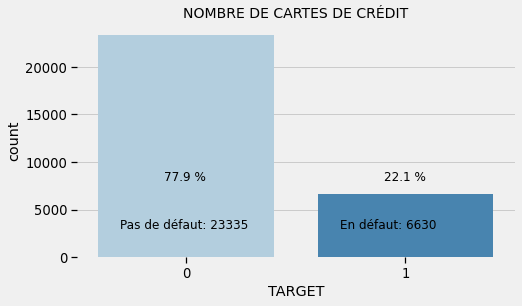

In [21]:
# La fréquence des défauts de paiement
yes = Bad_payers.TARGET.sum()
no = len(Bad_payers)-yes

# En pourcentage
yes_perc = round(yes/len(Bad_payers)*100, 1)
no_perc = round(no/len(Bad_payers)*100, 1)

import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('TARGET',data=Bad_payers, palette="Blues")
plt.annotate('Pas de défaut: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('En défaut: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('NOMBRE DE CARTES DE CRÉDIT', size=14)
#Removing the frame
plt.box(False);

<a id='stat'></a>
### Statistiques descriptives
Le tableau ci-dessous présente les statistiques descriptives des variables de cet ensemble de données.

In [22]:
set_option('display.width', 100)
set_option('precision', 2)

print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
print()
print(Bad_payers.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS

                     count       mean        std       min      25%       50%       75%       max
LIMIT_BAL          29965.0  167442.01  129760.14  1.00e+04  50000.0  140000.0  240000.0  1.00e+06
SEX                29965.0       0.60       0.49  0.00e+00      0.0       1.0       1.0  1.00e+00
EDUCATION          29965.0       0.84       0.74  0.00e+00      0.0       1.0       1.0  3.00e+00
MARRIAGE           29965.0       0.56       0.52  0.00e+00      0.0       1.0       1.0  2.00e+00
AGE                29965.0      35.49       9.22  2.10e+01     28.0      34.0      41.0  7.90e+01
DELAY APRIL        29965.0       1.61       0.95  0.00e+00      1.0       2.0       2.0  9.00e+00
DELAY MAY          29965.0       1.64       0.94  0.00e+00      1.0       2.0       2.0  9.00e+00
DELAY JUNE         29965.0       1.78       1.17  0.00e+00      1.0       2.0       2.0  1.00e+01
DELAY JULY         29965.0       1.84       1.20  0.00e+00      1.0       2.0  

La valeur moyenne du montant de la limite de la carte de crédit est de 167 442 NT dollars. L'écart-type est de 129.760 NT dollars, allant de 10.000 à 1M NT dollar.

Le niveau d'éducation est principalement de niveau supérieur (0) et universitaire (1). La plupart des clients sont mariés ou célibataires (l'autre statut est moins fréquent). L'âge moyen est de 35,5 ans, avec un écart-type de 9,2 ans. 

Concernant la suppression des outliers, nous avons testé mais ceci n'a eu aucun impact sur les prédictions du modèle. C'est pourquoi nous préférons les conserver pour prédire sur le plus de données possible.

<a id='catva'></a>
### Analyse des variables catégorielles

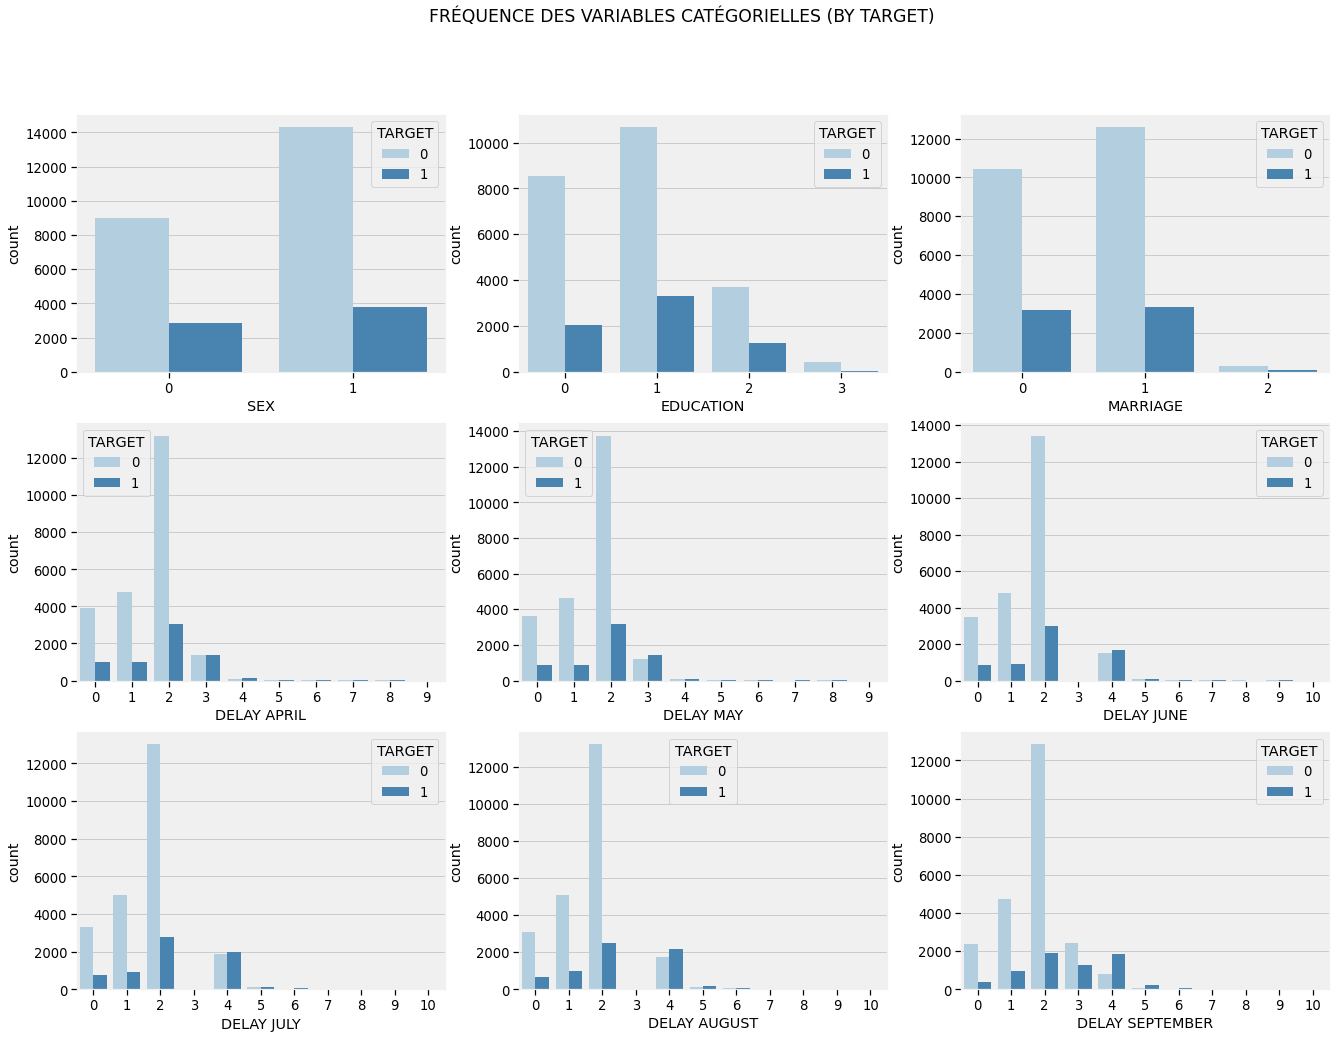

In [23]:
# Création d'un nouveau dataframe avec des variables catégorielles
subset = Bad_payers[['SEX', 'EDUCATION', 'MARRIAGE', 'DELAY APRIL', 'DELAY MAY', 'DELAY JUNE', 'DELAY JULY', 'DELAY AUGUST', 'DELAY SEPTEMBER', 'TARGET']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('FRÉQUENCE DES VARIABLES CATÉGORIELLES (BY TARGET)')
ax1 = sns.countplot(x="SEX", hue="TARGET", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="TARGET", data=subset, palette="Blues",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="TARGET", data=subset, palette="Blues",ax=axes[0,2])
ax4 = sns.countplot(x="DELAY APRIL", hue="TARGET", data=subset, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="DELAY MAY", hue="TARGET", data=subset, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="DELAY JUNE", hue="TARGET", data=subset, palette="Blues", ax=axes[1,2])
ax7 = sns.countplot(x="DELAY JULY", hue="TARGET", data=subset, palette="Blues", ax=axes[2,0])
ax8 = sns.countplot(x="DELAY AUGUST", hue="TARGET", data=subset, palette="Blues", ax=axes[2,1])
ax9 = sns.countplot(x="DELAY SEPTEMBER", hue="TARGET", data=subset, palette="Blues", ax=axes[2,2]);

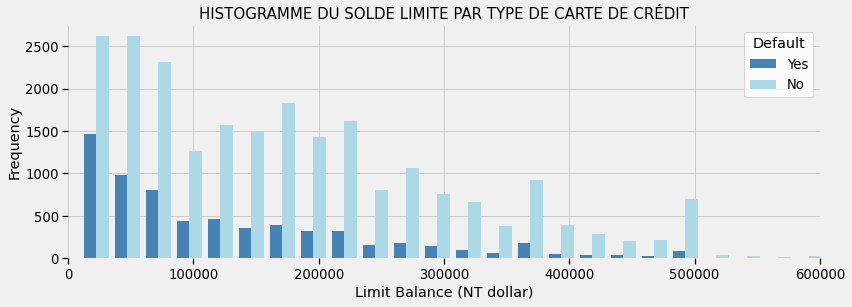

In [24]:
x1 = list(Bad_payers[Bad_payers['TARGET'] == 1]['LIMIT_BAL'])
x2 = list(Bad_payers[Bad_payers['TARGET'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, color=['steelblue', 'lightblue'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('HISTOGRAMME DU SOLDE LIMITE PAR TYPE DE CARTE DE CRÉDIT', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

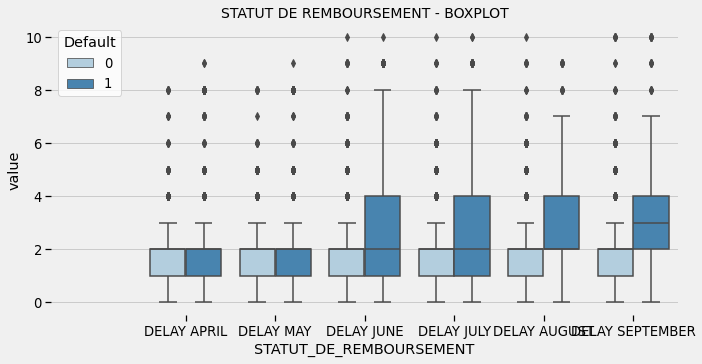

In [25]:
Repayment = Bad_payers[['TARGET', 'DELAY APRIL', 'DELAY MAY', 'DELAY JUNE', 'DELAY JULY', 'DELAY AUGUST', 'DELAY SEPTEMBER']]

Repayment = pd.melt(Repayment,id_vars="TARGET",
                    var_name="STATUT_DE_REMBOURSEMENT",
                    value_name='value')

plt.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="STATUT_DE_REMBOURSEMENT", hue="TARGET", data=Repayment, palette='Blues')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('STATUT DE REMBOURSEMENT - BOXPLOT', size=14)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200);

Il semble que le statut de remboursement en septembre et que le statut de remboursement en août aient un pouvoir discriminatoire plus important que le statut de remboursement des autres mois.

<a id='corr'></a>
### Corrélation
Une matrice de corrélation de toutes les variables est présentée dans la carte thermique ci-dessous. Les seules caractéristiques présentant une corrélation positive notable avec la variable dépendante "TARGET" sont le statut de remboursement au cours du dernier mois (septembre) ainsi que la variable synthétique "TOTAL DELAY" qui représente le délai total cumulé. La corrélation négative la plus élevée avec le défaut de paiement se produit avec Limit_Balance, ce qui indique que les clients dont le solde de la limite est inférieur sont plus susceptibles d'être en défaut de paiement. On peut également observer que certaines variables sont fortement corrélées entre elles, comme c'est le cas du montant du relevé de facture et de l'état de remboursement au cours des différents mois.

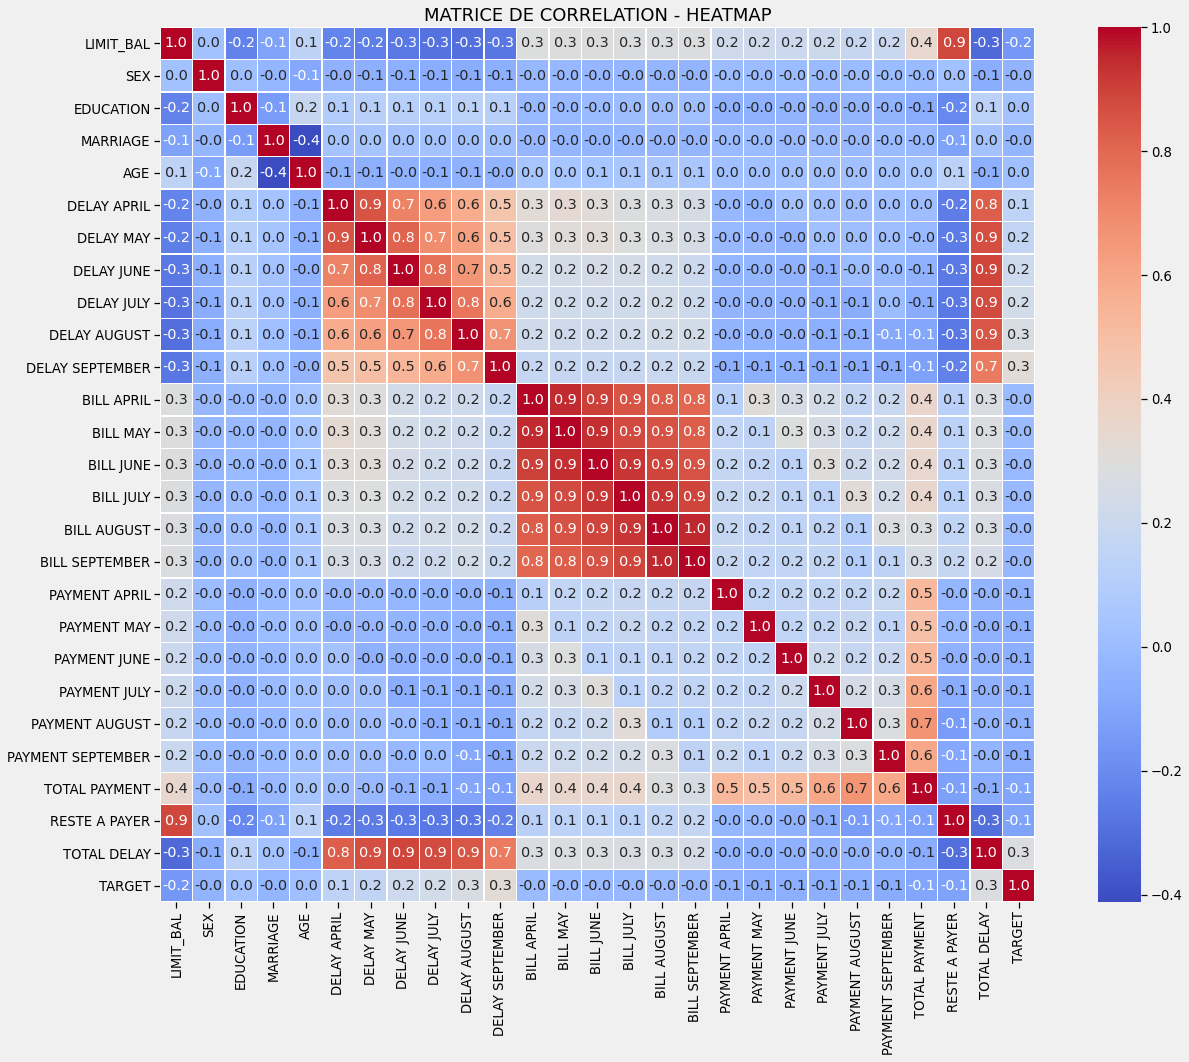

In [26]:
#  looking at correlations matrix, defined via Pearson function  
corr = Bad_payers.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, cbar = True,  square = True, annot = True, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('MATRICE DE CORRELATION - HEATMAP', size=18);

**Les données non corrélées sont potentiellement plus utiles : discriminantes !**

<a id='ml'></a>
## Apprentissage automatique : Modèles de classification


Pour construire des modèles d'apprentissage automatique, les données originales ont été divisées en caractéristiques (X) et en cible (y), puis divisées en ensembles d'entraînement (80%) et de test (20%). Ainsi, les algorithmes seront entraînés sur un ensemble de données et testés sur un ensemble de données complètement différent (non vu auparavant par l'algorithme).


<a id='sp'></a>
### Fractionnement des données en ensembles d'apprentissage et de test.

In [27]:
# Dataset with SMOTEd and MinMaxed features

X = Bad_payers.drop(cible, axis=1)
y = Bad_payers[cible]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

scale_minmax = MinMaxScaler()

# normaliser les données d'entrainement
for feature in cont_features:
    X_train[feature] = scale_minmax.fit_transform(X_train[feature].values.reshape(-1,1))
    
# normaliser les donnéees de test
for feature in cont_features:
    X_test[feature] = scale_minmax.fit_transform(X_test[feature].values.reshape(-1,1))

# La variable cible est très déséquilibrée
smt = SMOTE(random_state=0)

# Do the process
X_train, y_train = smt.fit_resample(X_train, y_train)

<a id='lr0'></a>
### Régression logistique
La régression logistique est l'un des algorithmes les plus simples qui estiment la relation entre une variable binaire dépendante et des variables indépendantes, en calculant la probabilité d'occurrence d'un événement. Le paramètre de régulation C contrôle le compromis entre l'augmentation de la complexité (surajustement) et le maintien de la simplicité du modèle (sous-ajustement). Pour de grandes valeurs de C, le pouvoir de régulation est réduit et le modèle augmente sa complexité, ce qui entraîne un surajustement des données.

In [28]:
# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression

# models
logreg = LogisticRegression(penalty='none')
logregRidge = LogisticRegression(penalty='l2')
logregLasso = LogisticRegression(penalty='l1', solver='saga')
logregElasticNet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25)

In [29]:
dict_models = {"Reression logistique": logreg,
              "Regression logistique + Ridge": logregRidge,
              "Regression logistique + Lasso": logregLasso,
              "Regression logistique + Elastic Net": logregElasticNet
              }

<a id='lr1'></a>
#### Régression logistique Simple

In [30]:
## régression logistique
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('='*20)
print('Régression logistique')
print('='*20, '\n')

print("Rapport de classification:")
print(classification_report(y_test, y_pred), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred)*100), '\n')
print('AUC: ', roc_auc_score(y_test, y_pred))

Régression logistique

Rapport de classification:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4680
           1       0.52      0.48      0.50      1313

    accuracy                           0.79      5993
   macro avg       0.69      0.68      0.68      5993
weighted avg       0.78      0.79      0.79      5993
 

Exactitude: 78.975471 

AUC:  0.6790852162139291


<a id='lr2'></a>
#### Régression logistique Ridge

In [31]:
## régression logistique + ridge
logregRidge.fit(X_train, y_train)
y_pred = logregRidge.predict(X_test)

print('='*30)
print('Régression logistique + Ridge')
print('='*30, '\n')

print("Rapport de classification:")
print(classification_report(y_test, y_pred), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred)*100), '\n')
print('AUC: ', roc_auc_score(y_test, y_pred))

Régression logistique + Ridge

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4680
           1       0.50      0.53      0.51      1313

    accuracy                           0.78      5993
   macro avg       0.68      0.69      0.69      5993
weighted avg       0.79      0.78      0.78      5993
 

Exactitude: 77.874187 

AUC:  0.6906638740797156


<a id='lr3'></a>
#### Régression logistique Lasso

In [32]:
## régression logistique + Lasso
logregLasso.fit(X_train, y_train)
y_pred = logregLasso.predict(X_test)

print('='*30)
print('Régression logistique + Lasso')
print('='*30, '\n')

print("Rapport de classification:")
print(classification_report(y_test, y_pred), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred)*100), '\n')
print('AUC: ', roc_auc_score(y_test, y_pred))

Régression logistique + Lasso

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4680
           1       0.46      0.59      0.52      1313

    accuracy                           0.76      5993
   macro avg       0.67      0.70      0.68      5993
weighted avg       0.78      0.76      0.77      5993
 

Exactitude: 76.072084 

AUC:  0.6980293221629855


<a id='lr4'></a>
#### Régression logistique Elasticnet

In [33]:
## régression logistique + elasticnet
logregElasticNet.fit(X_train, y_train)
y_pred = logregElasticNet.predict(X_test)

print('='*35)
print('Régression logistique + Elastic Net')
print('='*35, '\n')

print("Rapport de classification:")
print(classification_report(y_test, y_pred), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred)*100), '\n')
print('AUC: ', roc_auc_score(y_test, y_pred))

Régression logistique + Elastic Net

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4680
           1       0.46      0.59      0.52      1313

    accuracy                           0.76      5993
   macro avg       0.67      0.70      0.68      5993
weighted avg       0.78      0.76      0.77      5993
 

Exactitude: 76.105456 

AUC:  0.6982429973766607


La regression linéaire fournit des résultats moyens, le meilleur résultat est donné par ElasticNet :

**Exactitude: 76.105456** 

**AUC:  0.6982429973766607**

**F1-SCORE : 0.52**

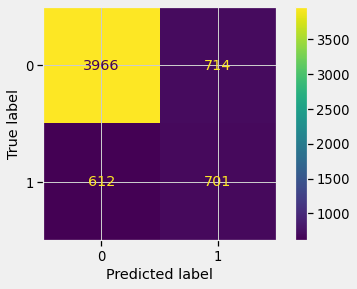

In [34]:
plot_confusion_matrix(logregRidge, X_test, y_test)
plt.show()

<a id='tree'></a>
### Decision Tree Classifier
L'arbre de décision est un autre algorithme très populaire pour les problèmes de classification car il est facile à interpréter et à comprendre. Un nœud interne représente une caractéristique, la branche représente une règle de décision, et chaque nœud feuille représente le résultat. Certains avantages des arbres de décision sont qu'ils nécessitent moins de prétraitement des données, c'est-à-dire qu'il n'est pas nécessaire de normaliser les caractéristiques. Cependant, les valeurs aberrantes peuvent facilement être surajustées et donner des résultats biaisés lorsque l'ensemble de données est déséquilibré.

In [35]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": range(1, 9),
              "max_features": range(1, 9),
              "min_samples_leaf": range(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 8, 'max_features': 5, 'max_depth': 6, 'criterion': 'gini'}


Exactitude: 0.7905890205239446
AUC:  0.683454980113396

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4680
           1       0.52      0.49      0.51      1313

    accuracy                           0.79      5993
   macro avg       0.69      0.68      0.69      5993
weighted avg       0.79      0.79      0.79      5993


Average 5-Fold CV Score: 0.8179 , Standard deviation: 0.0089


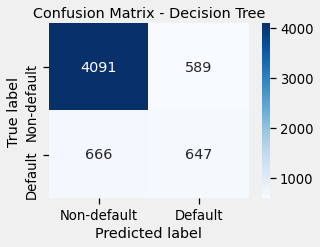

In [36]:
Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, min_samples_leaf= 8, 
                                     random_state=0)
Tree.fit(X_train, y_train)
y_pred = Tree.predict(X_test)
print('Exactitude:', metrics.accuracy_score(y_pred,y_test))
print('AUC: ', roc_auc_score(y_test, y_pred))
## 5-fold cross-validation 
cv_scores =cross_val_score(Tree, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)), 
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Tree.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

Les performances du Decision Tree Classifier sont similaires à celles de logregElasticNet :

**Exactitude: 0.7905890205239446**

**AUC:  0.683454980113396**

**F1-SCORE : 0.51**

<a id='rf'></a>
### Random Forest Classifier
Le classificateur Random Forest est composé de plusieurs arbres de décision. Il crée différents sous-ensembles aléatoires d'arbres de décision à partir de l'ensemble d'apprentissage comme ses prédicteurs et sélectionne la meilleure solution au moyen d'un vote. Par conséquent, le modèle Random Forest évite les problèmes de surajustement. 

In [37]:
# Create the random grid
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'entropy'}


Exactitude: 0.7887535458034374
AUC:  0.6978960396039604

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4680
           1       0.52      0.54      0.53      1313

    accuracy                           0.79      5993
   macro avg       0.69      0.70      0.70      5993
weighted avg       0.79      0.79      0.79      5993


Average 5-Fold CV Score: 0.8202 , Standard deviation: 0.0097


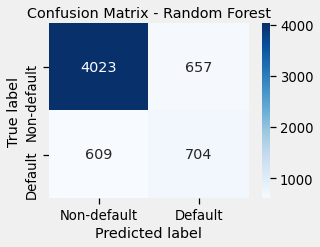

In [38]:
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Exactitude:', metrics.accuracy_score(y_pred,y_test))
print('AUC: ', roc_auc_score(y_test, y_pred))
## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

Les performances du Decision Tree Classifier sont similaires à celles de logregElasticNet avec une petite amélioration pour le F1-score :

**Exactitude: 0.7887535458034374**

**AUC:  0.6978960396039604**

**F1-SCORE : 0.53**

<a id='vecsup'></a>
### Machine à vecteurs de support
Les machines à vecteurs de support ou séparateurs à vaste marge sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. Les SVM sont une généralisation des classifieurs linéaires.

Exactitude - : 0.786
AUC:  0.6978960396039604
SVM_Model

Matrice de confusion:
[[3964  716]
 [ 564  749]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4680
           1       0.51      0.57      0.54      1313

    accuracy                           0.79      5993
   macro avg       0.69      0.71      0.70      5993
weighted avg       0.80      0.79      0.79      5993
 

Exactitude: 78.641749 



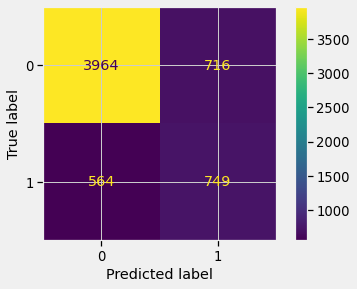

In [39]:
SVM_Model = SVC(gamma='auto', probability=True)
SVM_Model.fit(X_train,y_train)
print(f'Exactitude - : {SVM_Model.score(X_test,y_test):.3f}')
print('AUC: ', roc_auc_score(y_test, y_pred))
# predict
y_pred_train = SVM_Model.predict(X_train)
y_pred_test = SVM_Model.predict(X_test) 

print('='*20)
print('SVM_Model')
print('='*20, '\n')

print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred_test), '\n') # afficher à l'écran notre matrice de confusion
print("Rapport de classification:")
print(classification_report(y_test, y_pred_test), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred_test)*100), '\n')
plot_confusion_matrix(SVM_Model, X_test, y_test)
plt.show()

On améliore encore un peu le F1-Score sur la SVM :

**Exactitude: 0.786**

**AUC:  0.6978960396039604**

**F1-SCORE : 0.54**

<a id='vtcla'></a>
### Voting Classifier
Le Voting Classifier agrège simplement les résultats de chaque classificateur qui lui est transmis et prédit la classe de sortie en fonction de la majorité des votes.

In [40]:
voting = VotingClassifier([
    ('Régression logistique ElasticNet', logregElasticNet), 
    ('Decision Tree Classifier', Tree), 
    ('Random Forest Classifier', Ran),
    ('Machine à vecteurs de support', SVM_Model)
], voting = 'soft')

Rapport de classification:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4680
           1       0.52      0.57      0.55      1313

    accuracy                           0.79      5993
   macro avg       0.70      0.71      0.70      5993
weighted avg       0.80      0.79      0.79      5993
 

Exactitude: 79.042216 

AUC:  0.6978960396039604


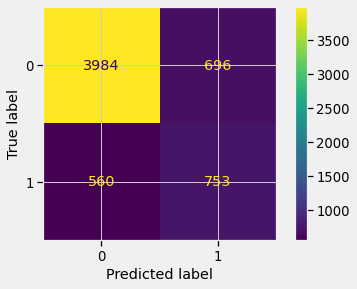

In [41]:
voting.fit(X_train, y_train)
voting.__class__.__name__, voting.score(X_test, y_test)
    
y_pred_train = voting.predict(X_train)
y_pred_test = voting.predict(X_test) 

print("Rapport de classification:")
print(classification_report(y_test, y_pred_test), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred_test)*100), '\n')
print('AUC: ', roc_auc_score(y_test, y_pred))
plot_confusion_matrix(voting, X_test, y_test)
plt.show()

Le vote aurait pu fonctionner, mais dans ce cas les performances ne sont qu'un peu affectées :

**Exactitude: 0.79042216**

**AUC:  0.6978960396039604**

**F1-SCORE : 0.55**

<a id='sum'></a>
## Comparaison des performances des modèles
Les métriques utilisées pour évaluer les performances des différents modèles : exactitude, précision, rappel, f1-score, AUC (ROC), et matrice de confusion ont été employées.

<a id='roc'></a>
### Courbe caractéristique d'exploitation du récepteur (ROC)
La courbe ROC (Receiver Operating Characteristic) est un tracé du taux de vrais positifs par rapport au taux de faux positifs. L'AUC est l'aire sous la courbe. Si l'AUC est élevée, le modèle distingue mieux les classes positives et négatives. La courbe ROC est tracée avec le "taux de vrais positifs" ou le rappel (sur l'axe des y) par rapport au "taux de faux positifs" (sur l'axe des x). Lorsque l'AUC est de 0,5, cela signifie que le modèle n'a aucune capacité de discrimination pour distinguer la classe positive de la classe négative.

La courbe ROC (Receiver operating characteristic) avec l'aire sous la courbe (AUC) respective est présentée ci-dessous pour chaque modèle.

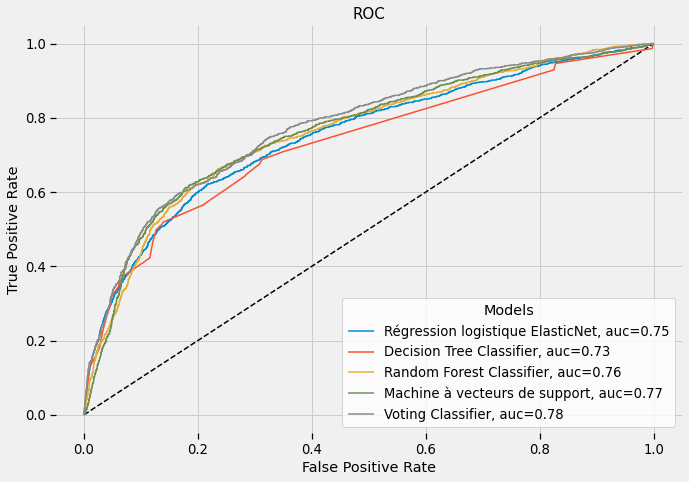

In [42]:
y_pred_proba_ElasticNet = logregElasticNet.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba_ElasticNet)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba_ElasticNet)

y_pred_proba_Tree = Tree.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba_Tree)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_Tree)

y_pred_proba_Ran = Ran.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba_Ran)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba_Ran)

y_pred_proba_SVM_Model = SVM_Model.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba_SVM_Model)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba_SVM_Model)

y_pred_proba_voting = voting.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba_voting)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba_voting)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Régression logistique ElasticNet, auc="+str(round(auc1,2)))
plt.plot(fpr2,tpr2,label="Decision Tree Classifier, auc="+str(round(auc2,2)))
plt.plot(fpr3,tpr3,label="Random Forest Classifier, auc="+str(round(auc3,2)))
plt.plot(fpr4,tpr4,label="Machine à vecteurs de support, auc="+str(round(auc4,2)))
plt.plot(fpr5,tpr5,label="Voting Classifier, auc="+str(round(auc5,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

L'AUC la plus élevée est obtenue pour le modèle Voting Classifier, avec une valeur de 0,78. Cela signifie qu'il y a 78 % de chances que le modèle soit capable de faire la distinction entre la classe défaut et la classe non-défaut.

<a id='ac'></a>
### Précision moyenne (coss-validation)
La précision est le rapport entre l'observation correctement prédite et l'ensemble des observations et c'est l'une des mesures les plus intuitives de la performance. Cependant, un taux de précision élevé ne signifie pas toujours que nous avons un modèle parfait. En fait, il ne fonctionne bien que lorsque les ensembles de données sont symétriques. Il peut être trompeur lorsque les classes sont déséquilibrées.

En utilisant la validation croisée K-fold, il est possible d'obtenir des modèles moins biaisés et d'éviter l'overfitting des données. Dans ce cas, on a utilisé une validation croisée 5 fois, comme le montre le code ci-dessous.

cv_scores = cross_val_score(Model, X, y, cv=5)

Après la validation croisée, il y a quatre valeurs de précision, donc il a été calculé la moyenne et l'écart-type de tous les résultats.

In [43]:
# Append different models
models = []

# Logistic Regression
models.append(('Logistic Regression',
               LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25)))

# Decision Tree Classifier
models.append(('Tree Classifier',
               DecisionTreeClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, min_samples_leaf= 8, 
                                     random_state=0)))

# Random Forest Classifier
models.append(('Random Forest Classifier',
               RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)))

# Machine à vecteurs de support
models.append(('Machine à vecteurs de support', SVC(gamma='auto', probability=True)))


# Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.778708 (0.000067)
Tree Classifier: 0.817921 (0.008906)
Random Forest Classifier: 0.820224 (0.009744)
Machine à vecteurs de support: 0.779276 (0.000940)


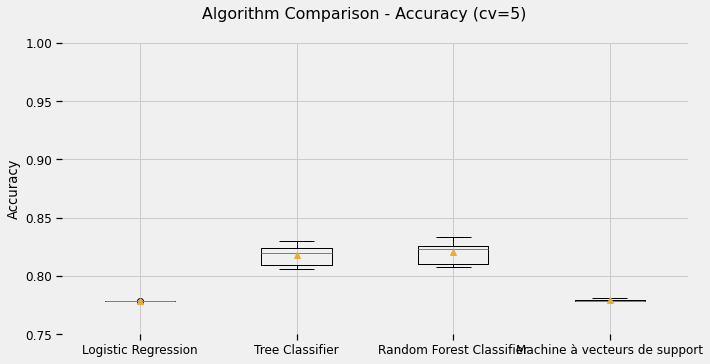

In [44]:
from matplotlib import pyplot
# Plot all the accuracy results vs. each model 
#(model type on the x-axis and accuracy on the y-axis).
fig = pyplot.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.1)
fig.suptitle('Algorithm Comparison - Accuracy (cv=5)')
ax = fig.add_subplot(111)
pyplot.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
ax.set_ylim([0.75,0.85])
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

La cross validation estime donc la part de chance dans la création du modèle.

On peut voir ici que les modèles les plus stables (les moins impactés par la part de hasard) sont la SVM et la régression logistique.

Quant à eux le Tree Classifier et le Random Forest sont des modèles plus soumis au hasard, même si leur précision moyenne est meilleure.

<a id='m'></a>
### Précision, Rappel, score F1
La précision d'un modèle est le rapport TP / (TP + FP). Dans ce cas, il s'agit de la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif. La précision est une bonne métrique à utiliser lorsque le coût des faux positifs (FP) est élevé.

Le rappel d'un modèle est le rapport TP / (TP + FN). Dans ce cas, il s'agit de la capacité du classificateur à trouver toutes les classes positives. Le rappel est une bonne métrique à utiliser lorsque le coût associé aux faux négatifs (FN) est élevé. Dans ce problème de classification, il y a un coût élevé pour la banque lorsqu'une carte de crédit en défaut est prédite comme n'étant pas en défaut, puisque aucune action ne peut être entreprise. Ainsi, le rappel est une métrique importante à laquelle il faut prêter attention.

Le score F1 est une moyenne pondérée de la précision et du rappel. Il prend donc en compte la FP et la FN. Cette métrique est très utile lorsque la distribution des classes est inégale, car elle recherche un équilibre entre la précision et le rappel.

In [45]:
from astropy.table import Table, Column
data_rows = [('Régression logistique ElasticNet', 'Smoted', 0.76, 0.59, 0.52),
              ('Decision Tree Classifier', 'Smoted', 0.79, 0.49, 0.51),
              ('Random Forest Classifier', 'Smoted', 0.79, 0.54, 0.53),
             ('Machine à vecteurs de support', 'Smoted', 0.79, 0.57, 0.54),
             ('Voting Classifier', 'Smoted', 0.79, 0.57, 0.55)
            ]
t = Table(rows=data_rows, names=('Model', 'Data', 'Exactitude', 'Recall', 'F1-min'))
print(t)

             Model                Data  Exactitude Recall F1-min
-------------------------------- ------ ---------- ------ ------
Régression logistique ElasticNet Smoted       0.76   0.59   0.52
        Decision Tree Classifier Smoted       0.79   0.49   0.51
        Random Forest Classifier Smoted       0.79   0.54   0.53
   Machine à vecteurs de support Smoted       0.79   0.57   0.54
               Voting Classifier Smoted       0.79   0.57   0.55


<a id='conc'></a>
## Conclusion

Lors de ce projet, nous avons pu essayer de nombreux autres près traitement et modèles, pour des raisons de lisibilité, nous avons choisi de ne représenter que les meilleurs dans ce présent document. Même si les résultats présentés peuvent paraitre moyen, nous avons pu les confronter avec d'autres modèles prédictifs trouvés en ligne sur le site Kaggle et il s'avère qu'ils tiennent très bien la route au final. Il arrive souvent sur ce genre de modèle que de nombreuses features soient manquantes et que le meilleur modèle ne soit pas en capacité de donner une réponse très pertinente. Cependant en se basant sur le ROC de notre meilleur modèle, à savoir le Voting Classifier qui repend tous nos précédents modèles pour les combiner, on peut avoir 78% de chance pour chaque prédiction qu'elle soit juste ce qui est tout de mème plutôt intéressant. L'objectif de ce dataset étant de contacter et d'avertir les éventuels futurs mauvais payeurs et pas de geler leur compte, cette prédiction peut être utilisée pour envoyer un mail de rappel pertinent dans 55% des cas alors que le hasard n'aurait été pertinent que dans 22% des cas.